# CNNの実装と可視化

## 要約

### レイヤ毎のデータのサイズ

1. layer into=>Conv1, x=>(5, 1, 28, 28)

ここでは最初の入力として、チャネル数1、H,W=28,28の画像が5枚入力されている。このため、入力が(5, 1, 28, 28)の行列が、Conv1に入る。

2. layer into=>Relu1, x=>(5, 30, 24, 24)

Convolution層で畳み込み計算が行われた結果、画像毎にフィルタが30枚、H,W=24,24(畳み込みしたので少し小さくなる)の重み行列ができる。
このため、(5, 30, 24, 24)行列がRelu1に渡る。

3. layer into=>Pool1, x=>(5, 30, 24, 24)

Reluは行列の各要素に演算を加えるのみのため、サイズは変更されない。引き続き、(5, 30, 24, 24)行列がPooling層に渡る。

3. layer into=>Affine1, x=>(5, 30, 12, 12)

Pooling層の結果H,Wのサイズが1/2に圧縮されて、Affine1に渡る。

4. layer into=>Relu2, x=>(5, 100)

Affine1の出力サイズは100(隠れ層のサイズとして最初にパラメタを設定）なので、(5,100) つまり、画像5枚毎のデータが、Relu2に渡る。

5. layer into=>Affine2, x=>(5, 100)

繰り返しになるが、Reluはサイズ変更なしなので、(5,100)がAffine2に渡る

6. layer into=>SoftmaxWithLoss, x=>(5, 10)

Affine2の出力として、パラメタ設定時に設定した最終出力サイズが10になる。ただし、画像毎のため、(5,10)行列になり、
それが最後のSoftmaxWithLossレイヤに渡り、損失（スカラー）が計算される。

### CNNデータの可視化

どうも、最初のW1層の重みを可視化すると意味がありそうな画像になるのだが、その他のW2やW3を可視化してもあまり意味のある画像が得られなかった。これはなぜだろうか。空間を考慮した計算をするConvolution層(W1)については、意味のありそうな学習をする様子。

# 以下、詳細

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from common.util import *
from common.layers import *
from my_common.util import init_sample_matrix
from simple_convnet import *
from dataset.mnist import load_mnist
%matplotlib inline

## テキストの写経

In [2]:
#テキストの写経
class SimpleConvNetMy:
   #input_dim=(1,28,28), \ #入力データの次元(チャンネル数、縦、横)
   #conv_param={"filter_num": 30, "filter_size": 5, "pad":0, "stride":1}, \ #畳み込み演算の各種パラメタ
   #hidden_size=100,\ #隠れ層のサイズ
   #output_size=10,\ #出力層のサイズ
   #weight_init_std=0.01):\ #重みの初期値の標準偏差
    def __init__(self, input_dim=(1,28,28), \
                 conv_param={"filter_num": 30, "filter_size": 5, "pad":0, "stride":1},\
                 hidden_size=100,\
                 output_size=10,\
                 weight_init_std=0.01,\
                 is_debug=True):\
        
        self.is_debug = is_debug
        
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_pad = conv_param["pad"]
        filter_stride = conv_param["stride"]
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1 # P212 の計算式
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        ##########################
        #パラメタの設定
        ##########################
        self.params = {}
        #テキストで説明の通り、重みはフィルタ枚数、チャンネル数、高さ、幅の４次元のデータになる、
        self.params["W1"] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        #バイアスはフィルタ毎に同一の値が重みの要素に加算されるため、フィルタ枚数毎に要素が設定される、１次元配列になる。
        self.params["b1"] = np.zeros(filter_num)
        
        self.params["W2"] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        
        self.params["b2"] = np.zeros(hidden_size)
        
        self.params["W3"] = weight_init_std * np.random.randn(hidden_size, output_size)
        
        self.params["b3"] = np.zeros(output_size)

        ##########################
        #レイヤの設定
        ##########################
        self.layers = {}
        self.layers["Conv1"] = Convolution(self.params["W1"],\
                                           self.params["b1"],\
                                           conv_param["stride"],\
                                           conv_param["pad"])
        
        self.layers["Relu1"] = Relu()
        
        self.layers["Pool1"] = Pooling(pool_h=2, pool_w=2, stride=2) #poolingのウインドウの幅、高さ、ストライドは固定値(テキストの説明通りの設定値となる)
        
        self.layers["Affine1"] = Affine(self.params["W2"], self.params["b2"])
        
        self.layers["Relu2"] = Relu()
        
        self.layers["Affine2"] = Affine(self.params["W3"], self.params["b3"])
        
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        if self.is_debug == False:
            for layer in self.layers.values():
                x = layer.forward(x)        
        else:
            for layer_name, layer in self.layers.items():
                print("layer into=>%s, x=>%s"%(layer_name, x.shape))
                x = layer.forward(x)        

        return x
    
    def loss(self, x , t):
        y = self.predict(x)
        if self.is_debug == True:
            print("layer into=>%s, x=>%s"%("SoftmaxWithLoss", y.shape))
        return self.last_layer.forward(y,t)
        
    def gradient(self, x, t):
        #forwardを一度実施する
        self.loss(x,t)
        
        #backwardを求める
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        laysers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
        
        #設定
        grads = {}
        grads["W1"] = self.layers["Conv1"].dW
        grads["b1"] = self.layers["Conv1"].db
        grads["W2"] = self.layers["Affine1"].dW
        grads["b2"] = self.layers["Affine1"].db
        grads["W3"] = self.layers["Affine2"].dW
        grads["b3"] = self.layers["Affine2"].db
        
        return grads

## 試しにデータを作って遊んで見る

In [3]:
#入力画像の高さ、幅、および、チャネル数。画像の枚数
H  = 4
W  = 5
C  = 1 #mnistはチャンネル数1のようなので、このサンプルテストもそれに合わせる(7.4.2と同じ)
N  = 1 #入力画像の枚数

#xの用意(mnistはチャンネル数1のようなので、このテストもそれに合わせる)
print("=== preparing of x===")
x1 = init_sample_matrix(filter_num = 1, channel=C, height=H, width=W) #filter番号(=画像番号)を識別する数値を与える(1,2~)
x = np.array([[x1]])
print(x.shape)
print(x)

=== preparing of x===
(1, 1, 4, 5)
[[[[1111 1112 1113 1114 1115]
   [1121 1122 1123 1124 1125]
   [1131 1132 1133 1134 1135]
   [1141 1142 1143 1144 1145]]]]


In [4]:
conv = SimpleConvNetMy(input_dim=(1,H,W))
for param_name, param in conv.params.items():
    print("param_name=%s, shape=%s"%(param_name, param.shape), )

param_name=W1, shape=(30, 1, 5, 5)
param_name=b1, shape=(30,)
param_name=W2, shape=(0, 100)
param_name=b2, shape=(100,)
param_name=W3, shape=(100, 10)
param_name=b3, shape=(10,)


極端に画像サイズが小さいと、重みサイズも変になる様子。

In [5]:
conv_text = SimpleConvNet(input_dim=(1,H,W))
for param_name, param in conv_text.params.items():
    print("param_name=%s, shape=%s"%(param_name, param.shape), )

param_name=W1, shape=(30, 1, 5, 5)
param_name=b1, shape=(30,)
param_name=W2, shape=(0, 100)
param_name=b2, shape=(100,)
param_name=W3, shape=(100, 10)
param_name=b3, shape=(10,)


このまま実行すると以下のエラーになるので、注意。

In [6]:
#conv.predict(x)
#conv_text.predict(x)
#for param_name, param in conv.params.items():
#    print("param_name=%s, shape=%s"%(param_name, param.shape), )
#for param_name, param in conv_text.params.items():
#    print("param_name=%s, shape=%s"%(param_name, param.shape), )

#layer into=>Conv1, x=>(1, 1, 4, 5)
#---------------------------------------------------------------------------
#ValueError                                Traceback (most recent call last)
#<ipython-input-6-1f00c5c38d27> in <module>
#----> 1 conv.predict(x)
#      2 conv_text.predict(x)
#      3 for param_name, param in conv.params.items():
#      4     print("param_name=%s, shape=%s"%(param_name, param.shape), )
#      5 for param_name, param in conv_text.params.items():
#
#<ipython-input-2-26ef0711306b> in predict(self, x)
#     68             for layer_name, layer in self.layers.items():
#     69                 print("layer into=>%s, x=>%s"%(layer_name, x.shape))
#---> 70                 x = layer.forward(x)
#     71 
#     72         return x
#
#~/deep-learning-from-scratch/common/layers.py in forward(self, x)
#    218         out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
#    219 
#--> 220         col = im2col(x, FH, FW, self.stride, self.pad)
#    221         col_W = self.W.reshape(FN, -1).T
#    222 
#
#~/deep-learning-from-scratch/common/util.py in im2col(input_data, filter_h, filter_w, stride, pad)
#     65             col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
#     66 
#---> 67     col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
#     68     return col
#     69 
#
#ValueError: cannot reshape array of size 0 into shape (0,newaxis)


## MNISTデータで試してみる、各レイヤの入力サイズを観察する

In [7]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
print(x_train.shape)

(60000, 1, 28, 28)


In [8]:
x_train, t_train = x_train[:5], t_train[:5]
#conv.predict(x_train)
conv = SimpleConvNetMy()
y = conv.loss(x_train,t_train)
print(y)

layer into=>Conv1, x=>(5, 1, 28, 28)
layer into=>Relu1, x=>(5, 30, 24, 24)
layer into=>Pool1, x=>(5, 30, 24, 24)
layer into=>Affine1, x=>(5, 30, 12, 12)
layer into=>Relu2, x=>(5, 100)
layer into=>Affine2, x=>(5, 100)
layer into=>SoftmaxWithLoss, x=>(5, 10)
2.302300626866902


1. layer into=>Conv1, x=>(5, 1, 28, 28)

ここでは最初の入力として、チャネル数1、H,W=28,28の画像が5枚入力されている。このため、入力が(5, 1, 28, 28)の行列が、Conv1に入る。

2. layer into=>Relu1, x=>(5, 30, 24, 24)

Convolution層で畳み込み計算が行われた結果、画像毎にフィルタが30枚、H,W=24,24(畳み込みしたので少し小さくなる)の重み行列ができる。
このため、(5, 30, 24, 24)行列がRelu1に渡る。

3. layer into=>Pool1, x=>(5, 30, 24, 24)

Reluは行列の各要素に演算を加えるのみのため、サイズは変更されない。引き続き、(5, 30, 24, 24)行列がPooling層に渡る。

3. layer into=>Affine1, x=>(5, 30, 12, 12)

Pooling層の結果H,Wのサイズが1/2に圧縮されて、Affine1に渡る。

4. layer into=>Relu2, x=>(5, 100)

Affine1の出力サイズは100(隠れ層のサイズとして最初にパラメタを設定）なので、(5,100) つまり、画像5枚毎のデータが、Relu2に渡る。

5. layer into=>Affine2, x=>(5, 100)

繰り返しになるが、Reluはサイズ変更なしなので、(5,100)がAffine2に渡る

6. layer into=>SoftmaxWithLoss, x=>(5, 10)

Affine2の出力として、パラメタ設定時に設定した最終出力サイズが10になる。ただし、画像毎のため、(5,10)行列になり、
それが最後のSoftmaxWithLossレイヤに渡り、損失（スカラー）が計算される。

## 重みを可視化

どうも、最初のW1層の重みを可視化すると意味がありそうな画像になるのだが、その他のW2やW3を可視化してもあまり意味のある画像が得られなかった。これはなぜだろうか。空間を考慮した計算をするConvolution層(W1)については、意味のありそうな学習をする様子。

(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)


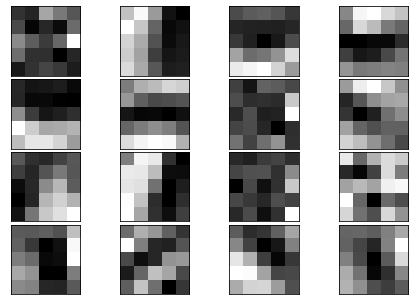

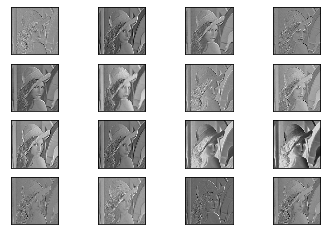

In [9]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
#    FN, C, FH, FW = filters.shape
#    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        print(filters[i,0].shape)
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), \
    conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},\
    hidden_size=100, output_size=10, weight_init_std=0.01)\

# 学習後の重み
network.load_params("params.pkl")

filter_show(network.params['W1'], 16)

img = imread('../dataset/lena_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(16):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

(4320, 100)
[[ 0.11121464  0.04927155 -0.02565418 ... -0.02497612  0.00938106
   0.00036471]
 [ 0.10288589  0.04362536  0.00556306 ... -0.03265214  0.00874581
   0.00759615]
 [ 0.11025869 -0.01323248 -0.00162838 ...  0.05269614  0.00767294
   0.0045457 ]
 ...
 [-0.2003468   0.01552635 -0.00286005 ... -0.0453153   0.00410351
  -0.00146703]
 [-0.03717559  0.0458177   0.010786   ... -0.1919872  -0.0077879
   0.00622923]
 [-0.13649845  0.21539438  0.00044387 ... -0.04977478 -0.01189769
   0.00476314]]


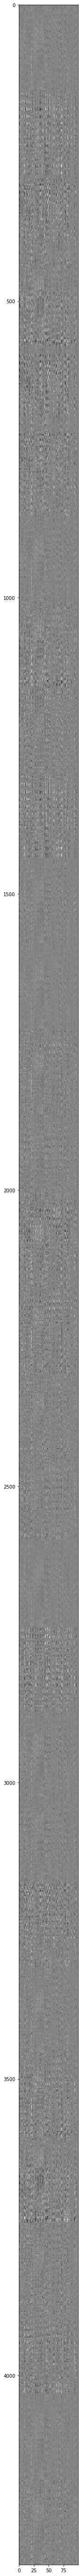

(100, 10)
[[-1.03326422e-01  3.81111614e-02  1.67710279e-01 -3.98341688e-02
   1.52949033e-01 -2.52616485e-01  3.64429829e-02  8.14899358e-02
  -3.62936978e-01  2.82722684e-02]
 [-3.14819997e-01  6.94956734e-02  1.59344867e-01  2.96865656e-02
  -4.45483747e-01 -7.32348880e-02 -4.22371414e-02  2.53665984e-01
  -3.74970195e-02 -4.53285231e-01]
 [-6.27363063e-03 -2.09431077e-02 -1.73454104e-02 -8.22059811e-03
  -2.40512313e-02 -1.58705589e-02  2.90116776e-02  2.96996324e-02
   1.06881037e-02 -3.04697148e-02]
 [-1.31186817e-01 -1.36974515e-01 -2.20531338e-01 -7.05584648e-02
   3.37120999e-02  6.42827644e-02 -3.32708742e-03  7.08614747e-02
   5.60466722e-02  7.43840292e-02]
 [ 1.51407069e-02  2.34828605e-03  1.62847104e-02 -5.35708819e-02
   3.73633993e-02 -3.16964853e-02  1.26101307e-02  1.66834148e-02
   3.21369030e-04 -2.73531901e-02]
 [-1.21645749e-01 -1.92129301e-01  1.72396748e-01 -7.32630542e-02
  -1.80226172e-01 -4.88225183e-02 -5.11025748e-02  1.34192498e-01
   1.66174378e-01 -1.21

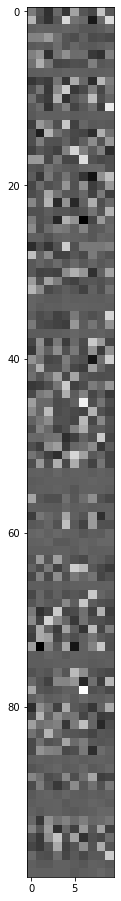

In [10]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

import matplotlib
#matplotlib.pyplot.rcParams['figure.figsize'] = (65535.0, 65535.0)
#matplotlib.pyplot.rcParams['figure.figsize'] = (16.0, 16.0)


def one_filter_show(one_filter, nx=4, show_num=1):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    #FN, C, FH, FW = filters.shape
    print(one_filter.shape)
    ny = int(np.ceil(show_num / nx))

    #画像をarrayに変換
    #im_list = np.asarray(one_filter)
    #貼り付け
    #plt.imshow(im_list,cmap=plt.cm.gray_r, interpolation='nearest')
    #表示
    #plt.show()
    
    #one_filter = one_filter[:500,:500]
    plt.imshow(one_filter,cmap=plt.cm.gray_r, interpolation='nearest')
    print(one_filter)
    plt.show()
    
    #plt.imshow(one_filter)
#    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

#    for i in range(show_num):
#        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
#        img_temp = filter[i].reshape(28,-1)
#        ax.imshow(img_temp, cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), \
    conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},\
    hidden_size=100, output_size=10, weight_init_std=0.01)\

# 学習後の重み
network.load_params("params.pkl")

matplotlib.pyplot.rcParams['figure.figsize'] = (100.0, 100.0)
one_filter_show(network.params['W2'], 16)
matplotlib.pyplot.rcParams['figure.figsize'] = (16.0, 16.0)
one_filter_show(network.params['W3'], 16)

#plt.show()

In [11]:
aaa = np.array([[1,2,3,4,5],[6,7,8,9,0]])
print(aaa)
b = aaa[:1,:2]
print(b.shape)
print(b)

[[1 2 3 4 5]
 [6 7 8 9 0]]
(1, 2)
[[1 2]]


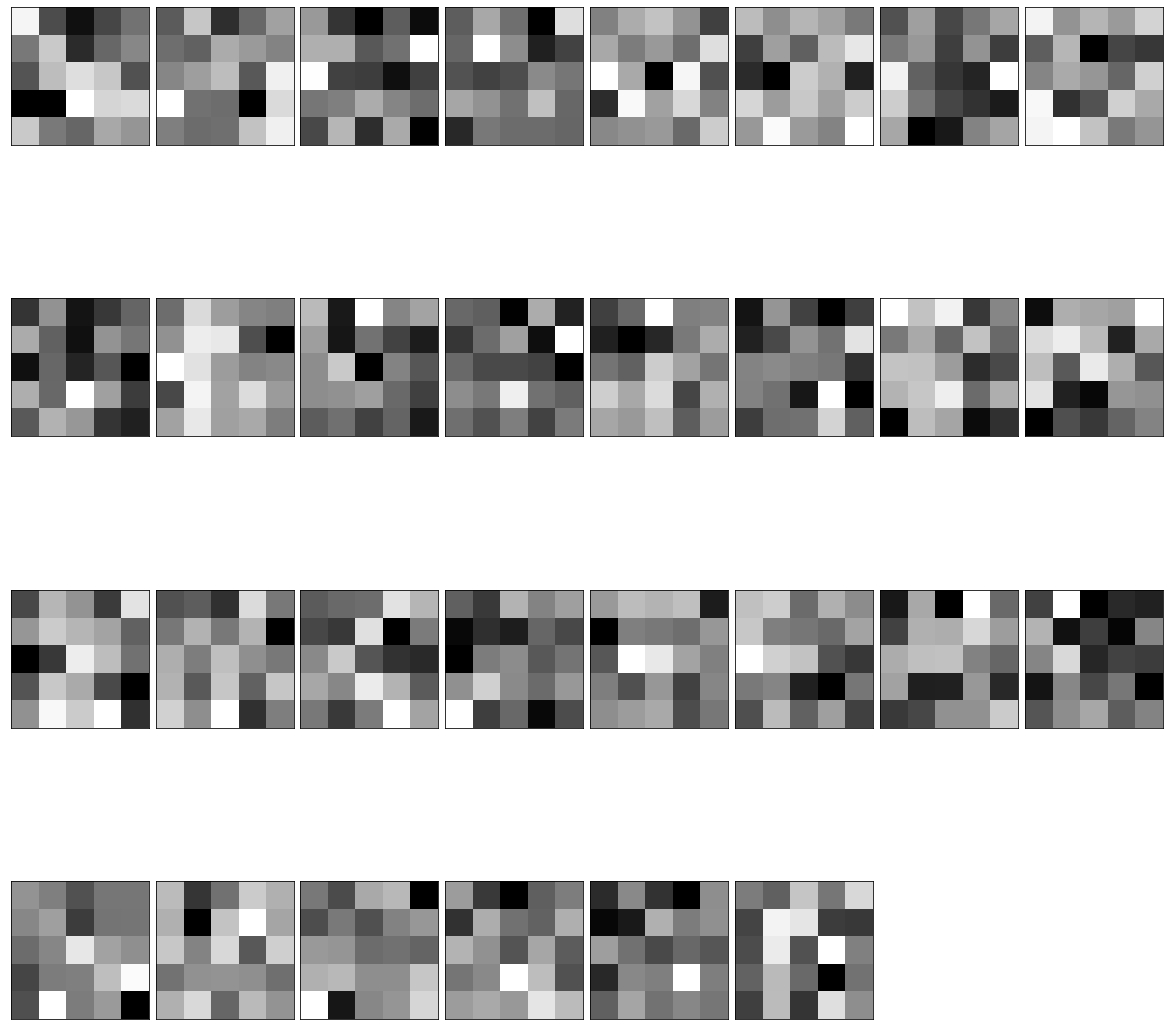

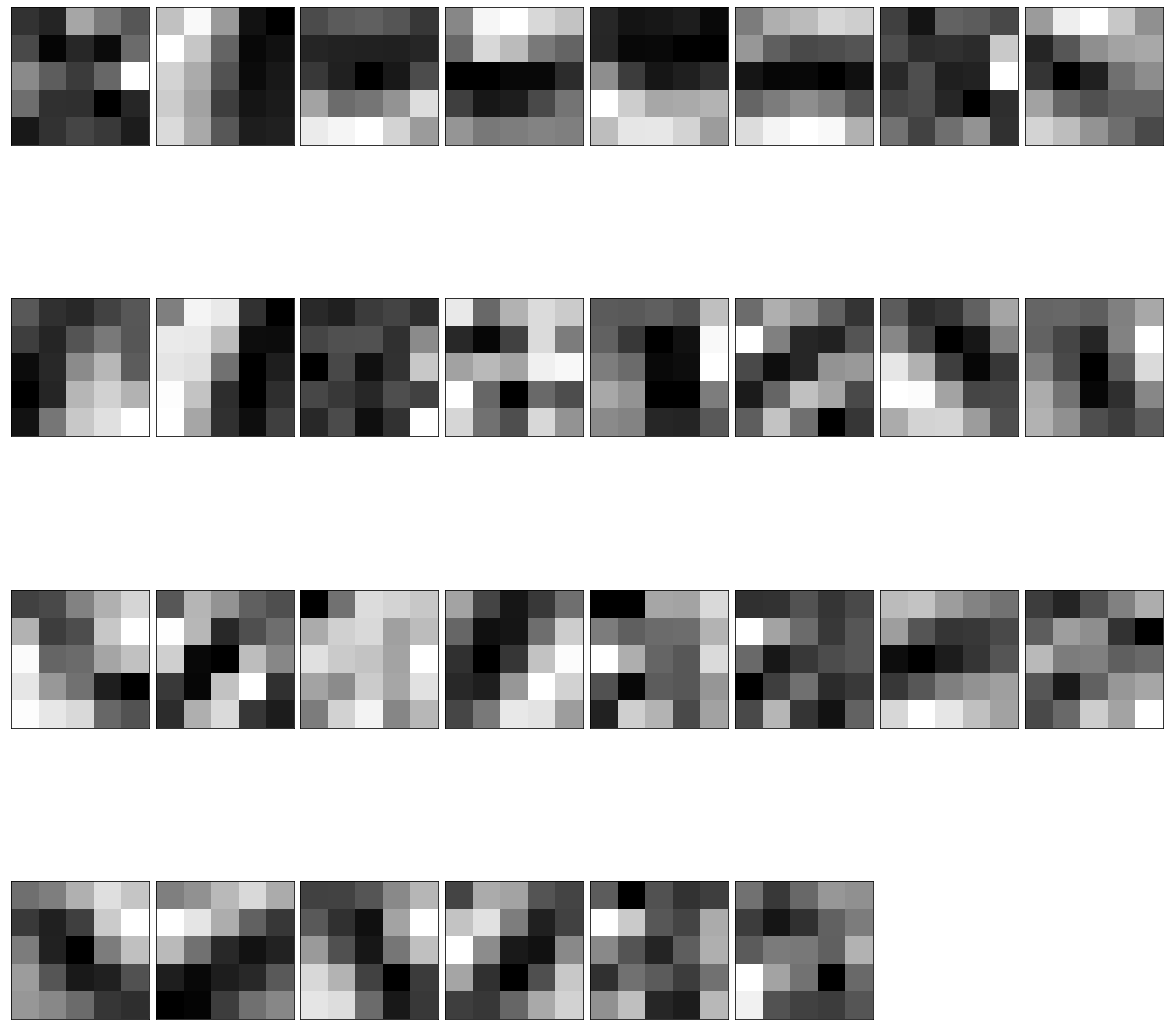

30


In [12]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

print(len(network.params['W1']))
